 ## In this notebook, I will try to apply ***Lee-Carter models*** to build a prospective life table usind data from the Human mortality database.	

### About Lee-carter models :###
1. #### Notation : ####
Classically, we denote the observed deaths of a person of age $ x $ in year $ t $ $ d_ {xt} $, the number of person of age $ x $ in year $ t $ exposed to the risk of mortality $ E_ {xt} ^ {0} $, the central risk exposure (i.e. the center of the square $ (x, t) $ of the Lexis diagram) $ E_{xt} ^{c} $. \
The estimate of the quotient of mortality at age $ x $ in years $ t $ is provided by the relation $ q_ {xt} = \frac{d_{xt}}{E_ {xt}^{0}} $, of the rate death: $ \mu_{xt} = \frac{d_{xt}}{E_{xt}^{c}} $. Assuming a uniform distribution, we have: $ E_{xt}^{0} = E_{xt}^{c} + \frac{1}{2} d_{xt}$ \
We also conventionally assume that the random variable which models the deaths of age $ x $ in year $ t $ follows a binomial distribution: $ D_ {xt} \hookrightarrow \mathbb{B} (E_{xt} ^{0}, q_{xt}) $
2.  Lee-carter model : 
The Lee-Carter Model assumes a binomial distribution of deaths and uses a logit link function: 

$$  logit(q_ {xt}) = \alpha_{x} + \beta_{x} \kappa_{t} $$ 

*  $ \alpha_{x} $: captures the general shape of mortality by age
*  $ \beta_{x} $: captures the contribution by ages of the effects of the mortality trends

* $ \kappa_{t} $: describes the evolution of mortality over time.

To guarantee the identifiability of the model, we also suppose that: $\sum_{t} \kappa_{t} =0 $ and $ \sum_{x} \beta_{t} = 1 $ \
To project the mortality detected by the component $ \kappa_ {t} $, we assume that it follows a random walk process: $\kappa_{t} = \delta + \kappa_{t-1} + \epsilon_{t} $.


3.   Renshaw et Haberman model : 

This is a model similar to the Lee-Carter model except that it assumes the existence of a component that models the cohort effect: 
$$  logit(q_{xt}) = \alpha_{x} + \beta_{x} \kappa_{t} + \gamma_{t-x} $$ 

In [6]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

character(0)

The packages "StMoMo" in **R** helps a lot in fitting and forecasting the data. 


## Initialisation :

In [7]:
install.packages("demography")
install.packages("StMoMo")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ftsa’, ‘rainbow’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [8]:
library(demography)
library(MortalitySmooth)
library(StMoMo)

Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'demography':
  method      from 
  print.lca   e1071
  summary.lca e1071

This is demography 1.22 


Loading required package: svcm

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: splines


Attaching package: ‘svcm’


The following object is masked from ‘package:ggplot2’:

    resolution


Loading required package: lattice

Loading required package: gnm


Attaching package: ‘gnm’


The following object is masked from ‘package:lattice’:

    barley




In [9]:
fra = hmd.mx("FRATNP", "email", "password","FRA") 
fra1 = StMoMoData(fra,series="male")
fra2 = central2initial(fra1)

ERROR: Error in hmd.mx("FRATNP", "email", "password", "FRA"): Connection error at www.mortality.org. Please check username, password and country label.


In [11]:
fra1

Mortality data for FRA
    Series:  male
    Years: 1816 - 2017
    Ages:  0 - 110
    Exposure:  central 

In [12]:
fra2 = central2initial(fra1)

Here is a graph that describe the evolution of mortality by ages and by years

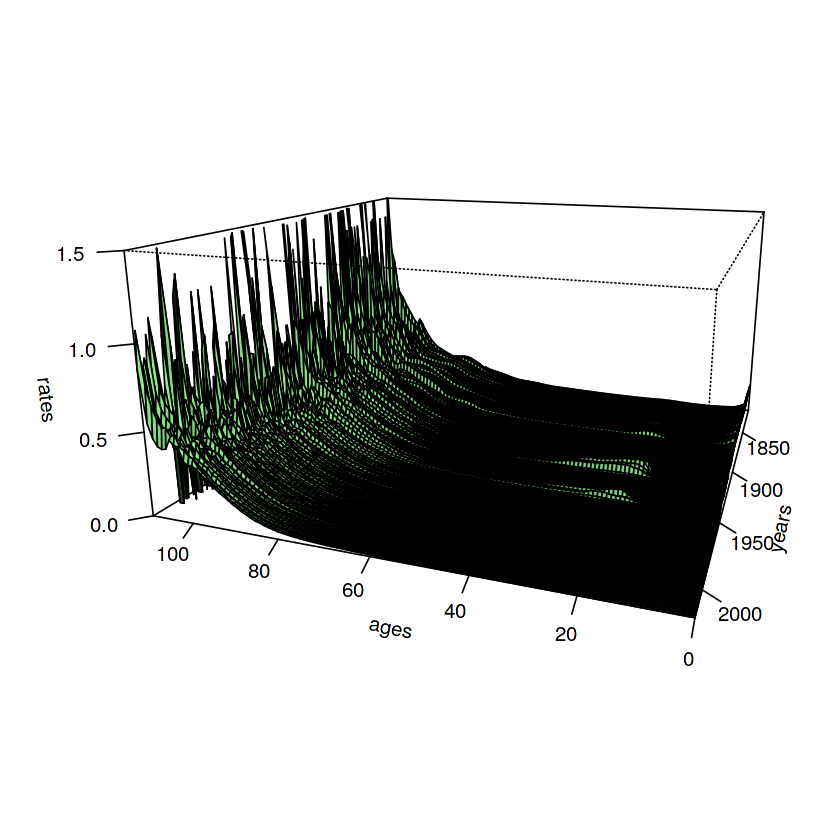

In [13]:
persp(fra2$ages,fra2$years,fra2$Dxt/fra2$Ext,theta=-160,phi=15,xlab='ages',ylab='years',zlab='rates',col="lightgreen",expand=0.5,shade=0.8,ticktype="detailed")


#### Lets explore our mortality rates in a transversale way : for example lets compare mortality rates by ages of 2000 and 2017 ####

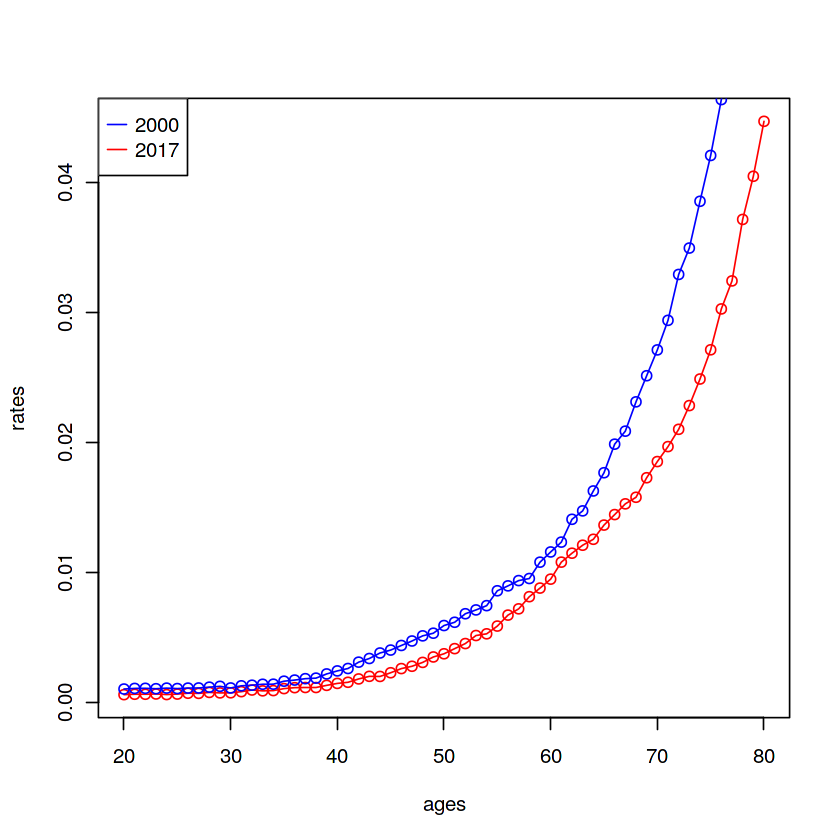

In [14]:



plot(20:80,fra2$Dxt[21:81,202]/fra2$Ext[21:81,202],type="o",col="red",xlab='ages',ylab='rates')
lines(20:80,fra2$Dxt[21:81,185]/fra2$Ext[21:81,185],type="o",col="blue",xlab='ages',ylab='rates')
text=c("2000","2017")
legend("topleft", lty=1,
       legend=text, 
       col =c("blue","red"),
       text.width = strwidth(text)[1]*2)


## Model fitting :

In [15]:
LC <- lc(link = "logit")
RH <- rh(link = "logit", cohortAgeFun = "1")



StMoMo: The following cohorts have been zero weigthed: 1731 1732 1733 1960 1961 1962 
StMoMo: Start fitting with gnm
Initialising
Running start-up iterations..
Running main iterations......
Done
StMoMo: Finish fitting with gnm


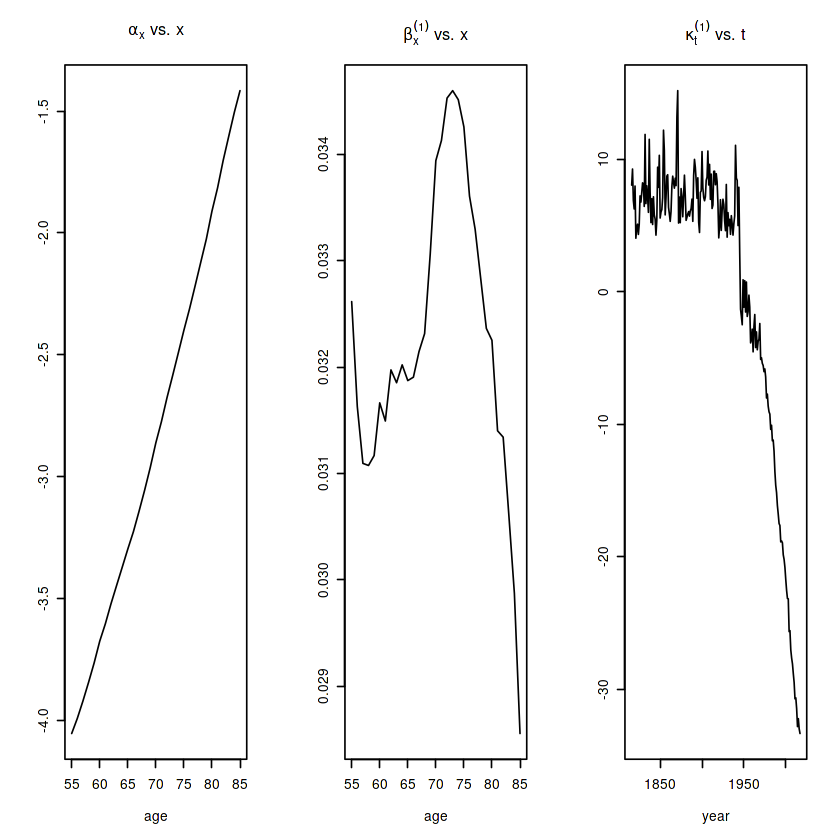

In [16]:


ages.fit <- 55:85
wxt <- genWeightMat(ages = ages.fit, years = fra2$years,
                    clip = 3)
LCfit <- fit(LC, data = fra2, ages.fit = ages.fit, wxt = wxt)


plot(LCfit, nCol = 3)



StMoMo: The following cohorts have been zero weigthed: 1731 1732 1733 1960 1961 1962 
StMoMo: Start fitting with gnm
Initialising
Running main iterations..................................
Done
StMoMo: Finish fitting with gnm


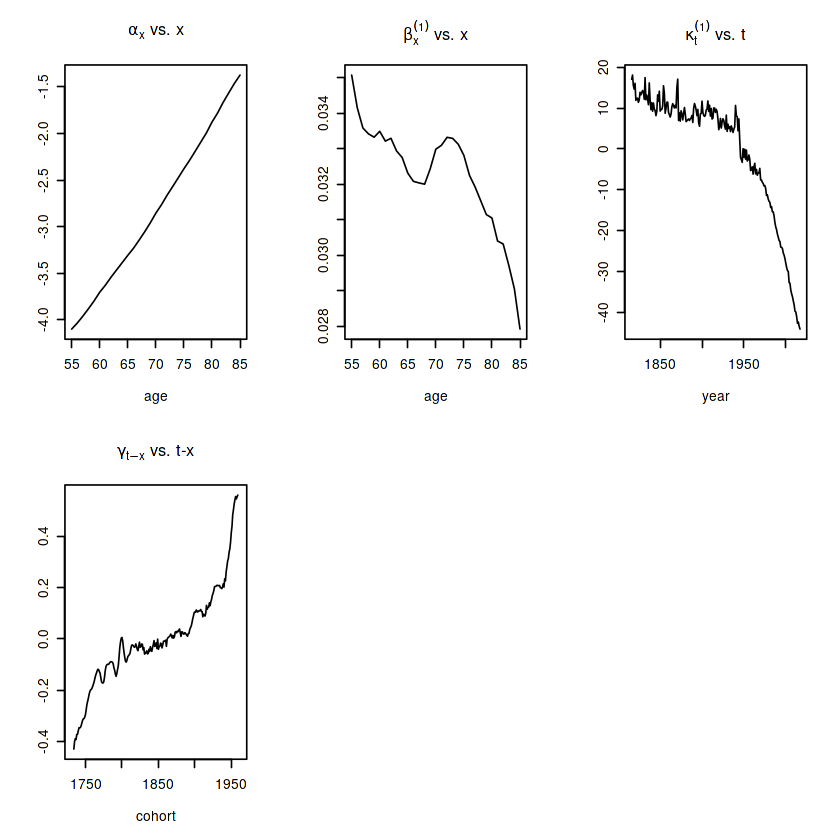

In [17]:
 


RHfit <- fit(RH, data = fra2, ages.fit = ages.fit, wxt = wxt,
             start.ax = LCfit$ax, start.bx = LCfit$bx, start.kt = LCfit$kt)

plot(RHfit, parametricbx = FALSE,nCol = 3)



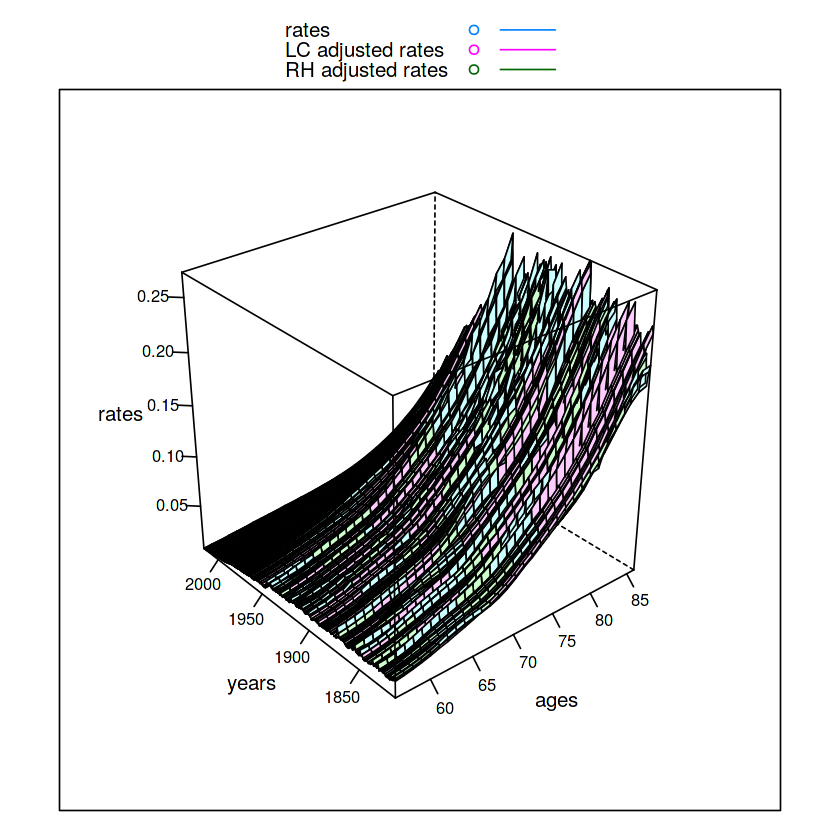

In [18]:
library(lattice)

## taux ajustés vs taux bruts
x=LCfit$ages
y=LCfit$years
g<-expand.grid(x=56:86,y,gr=1:3)

g$z<-c(fra2$Dxt[56:86,]/fra2$Ext[56:86,],fitted(LCfit, type = "rates"),fitted(RHfit, type = "rates"))

wireframe(z ~ x * y, data = g, groups = gr,scales = list(arrows = FALSE),
          auto.key=list(text=c("rates","LC adjusted rates","RH adjusted rates"),lines=TRUE),
          xlab="ages",ylab="years",zlab="rates")
##


We see that the effect of age represented by $ \alpha_{x} $ increases almost linearly for the two models, it's normal that death increases with age. \
The beta which models the interaction of age with the effect of years shows that the effect of age outweighs the effect of years in the 70-80 age group. The effect of mortality which models time is clearly decreasing!

## Residual analysis :

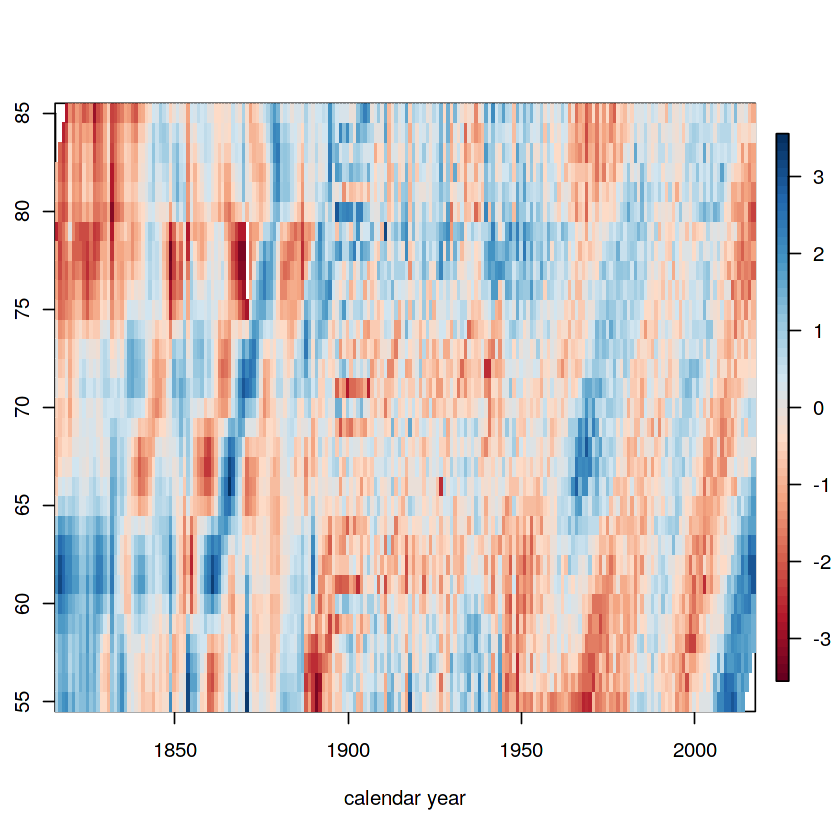

In [19]:

LCres <- residuals(LCfit)

plot(LCres, type = "colourmap", reslim = c(-3.5, 3.5))


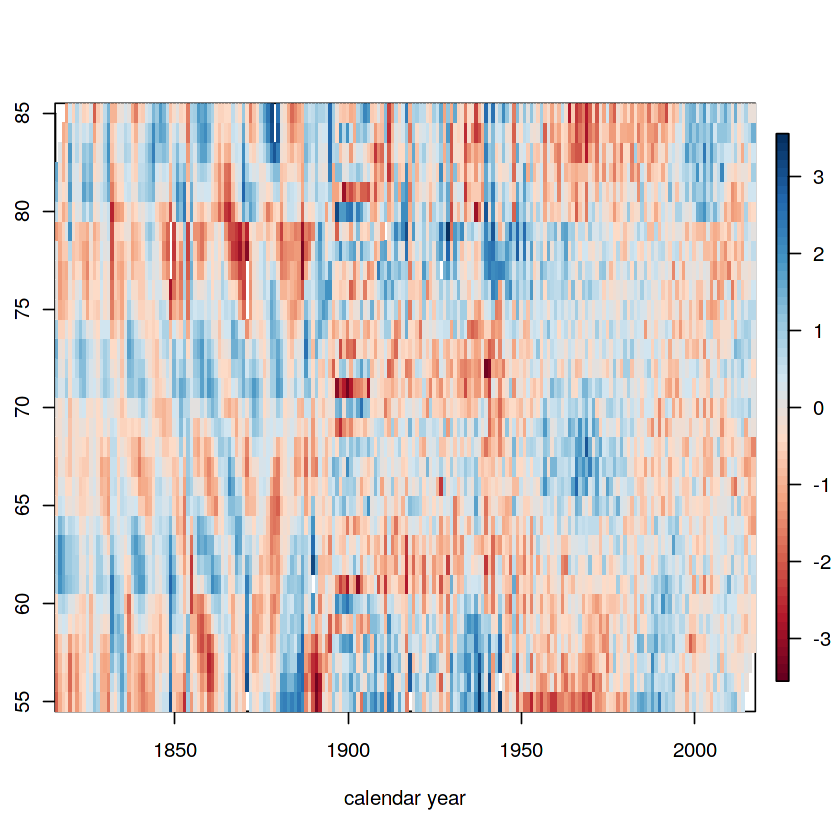

In [20]:
RHres=residuals(RHfit)
plot(RHres, type = "colourmap", reslim = c(-3.5, 3.5))


We see in the first colourmap that there are still cohort effects structures (lines with the same color) which put in the assumptions of normality of the residues. \
RH performs better since it models an additional effect than LC, but it is more parameterized.\ 
Referring to the Akaike Information Criteria (AIC):

In [22]:
AIC(LCfit);AIC(RHfit)



[1] 114969.1

[1] 89582.71

### Forecasting :

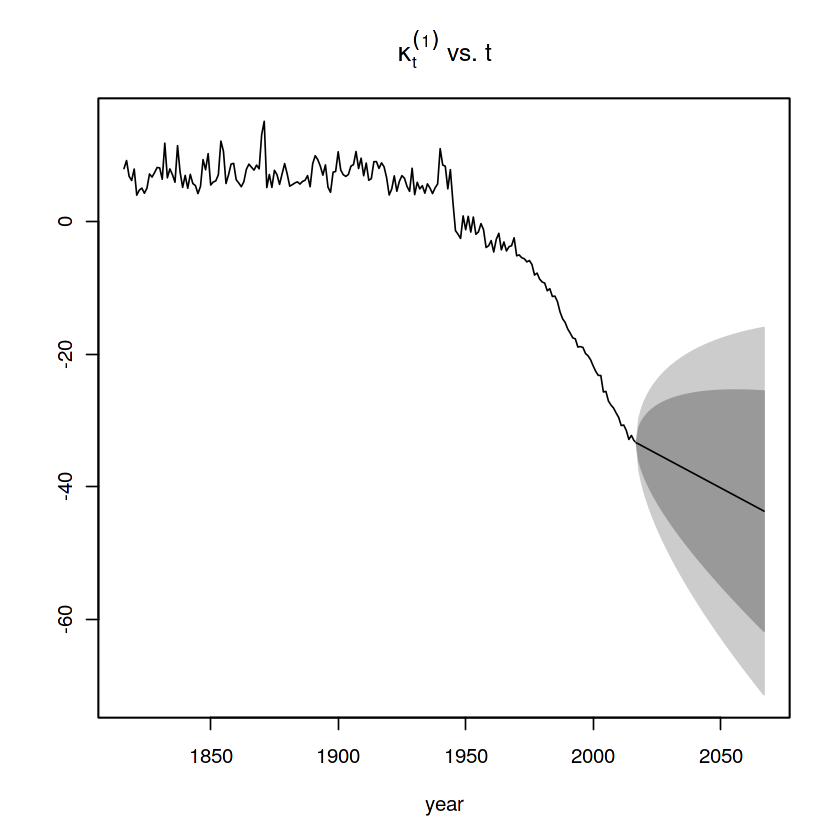

In [21]:
LCfor <- forecast(LCfit, h = 50)
plot(LCfor, only.kt = TRUE)


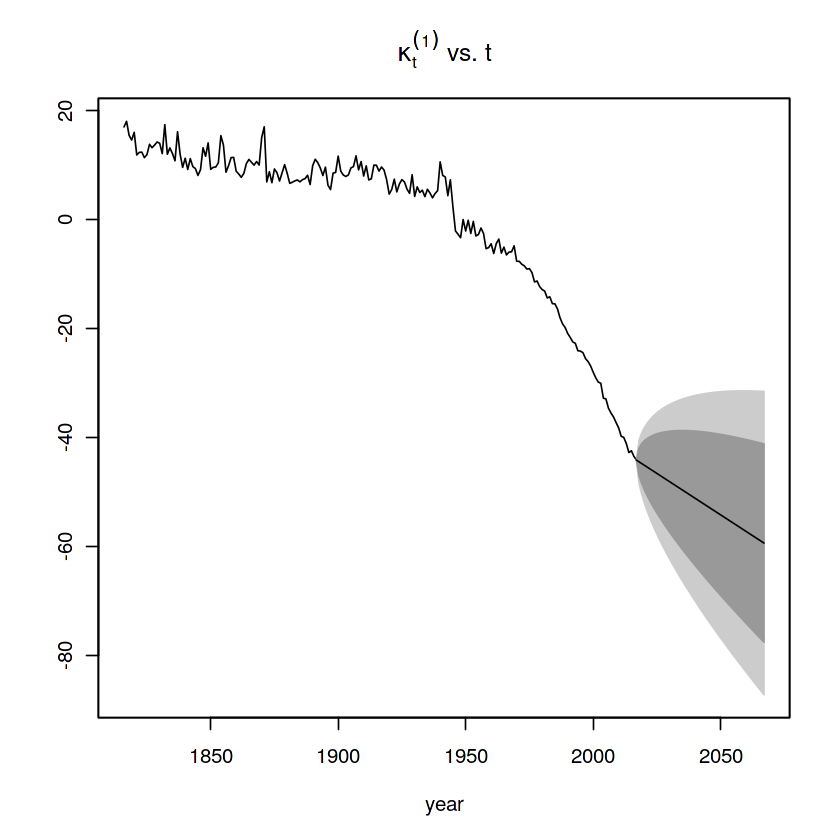

In [23]:
RHfor <- forecast(RHfit, h = 50, gc.order = c(1, 1, 0))
plot(RHfor,only.kt=TRUE)


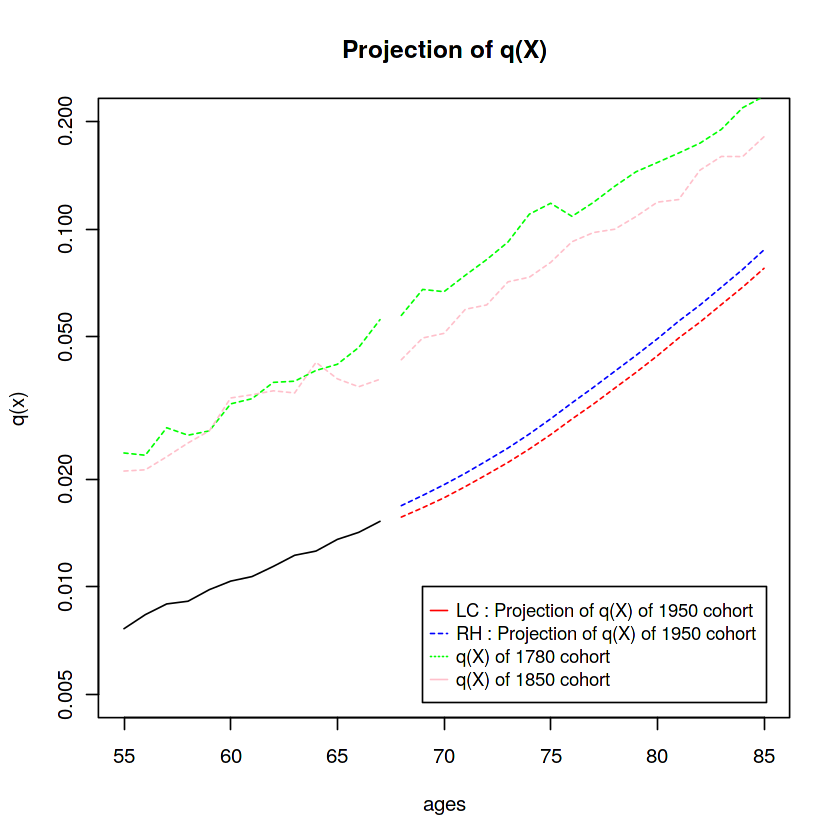

In [24]:
plot(55:67, extractCohort(fra2$Dxt[56:68,]/fra2$Ext[56:68,], cohort = 1950),
     type = "l", log = "y", xlab = "ages", ylab = "q(x)",
     main = "Projection of q(X)",
     xlim = c(55,85), ylim = c(0.005, 0.2))
lines(68:85, extractCohort(RHfor$rates, cohort = 1950), pch=19,lty = 2,col="blue")
lines(68:85, extractCohort(LCfor$rates, cohort = 1950),pch=18, lty = 2,col="red")
lines(55:67,extractCohort(fra2$Dxt[56:68,]/fra2$Ext[56:68,], cohort = 1780),pch=20, lty = 2,col="green")
lines(55:67,extractCohort(fra2$Dxt[56:68,]/fra2$Ext[56:68,], cohort = 1880),pch=20, lty = 2,col="pink")

lines(68:85,extractCohort(fra2$Dxt[69:86,]/fra2$Ext[69:86,], cohort = 1780),pch=20, lty = 2,col="green")
lines(68:85,extractCohort(fra2$Dxt[69:86,]/fra2$Ext[69:86,], cohort = 1880),pch=20, lty = 2,col="pink")

text=c("LC : Projection of q(X) of 1950 cohort","RH : Projection of q(X) of 1950 cohort","q(X) of 1780 cohort ","q(X) of 1850 cohort ")
legend(69,0.01,legend=text,col =c("red","blue","green","pink"),lty=1:3,text.width = strwidth(text)[1]*1.8, cex=0.9)


## Closing-out our life table :

After projecting the mortality trend for the 1950 cohort, the death probabilities were developed according to the model of Renshaw and Haberman; model which takes into account the effect of mortality by cohort. \
In order to be able to construct a mortality table with these projected probabilities, it's necessary to make assumptions about the closure of the table in a rather particular way.

 ### Denuit and Gordeniaux Model : ###
 This model was proposed by Denuit and Goderniaux in 2005 : 
    For $ x>85$ years  old : $$ ln (q_{xt}) = a_t + b_t x + c_t x ^ 2 + \epsilon_{xt} $$
    We choose as age limit $ x_{lim} = 110ans $. \
    This will allow us to compare our table with the regulatory tables. \
   The following conditions are imposed on the previous model: $ q_{110,t} = $ 1 ; $ \frac{dq_{xt}}{dx}_{| 110,t}= 0 $
 

In [25]:

ageferm2=(110-(86:110))^2
extractCohort(fra2$Dxt[56:68,]/fra2$Ext[56:68,], cohort = 1950)
regferm=lm(log(fra2$Dxt[87:111,202]/fra2$Ext[87:111,202])~ageferm2)


55          56          57          58          59          60 
0.007644667 0.008367843 0.008963646 0.009121211 0.009827472 0.010381828 
         61          62          63          64          65          66 
0.010689560 0.011413492 0.012259390 0.012597153 0.013577200 0.014206368 
         67 
0.015251798

Let's import the moroccan regulatory life table : TD 88-90

In [27]:
ltable=read.csv2("../input/french-life-tables-tdtv8890/TDTV8890.csv")

Warning message in -diff(ltable$Lx.TD.88.90)/ltable$Lx.TD.88.90:
“longer object length is not a multiple of shorter object length”


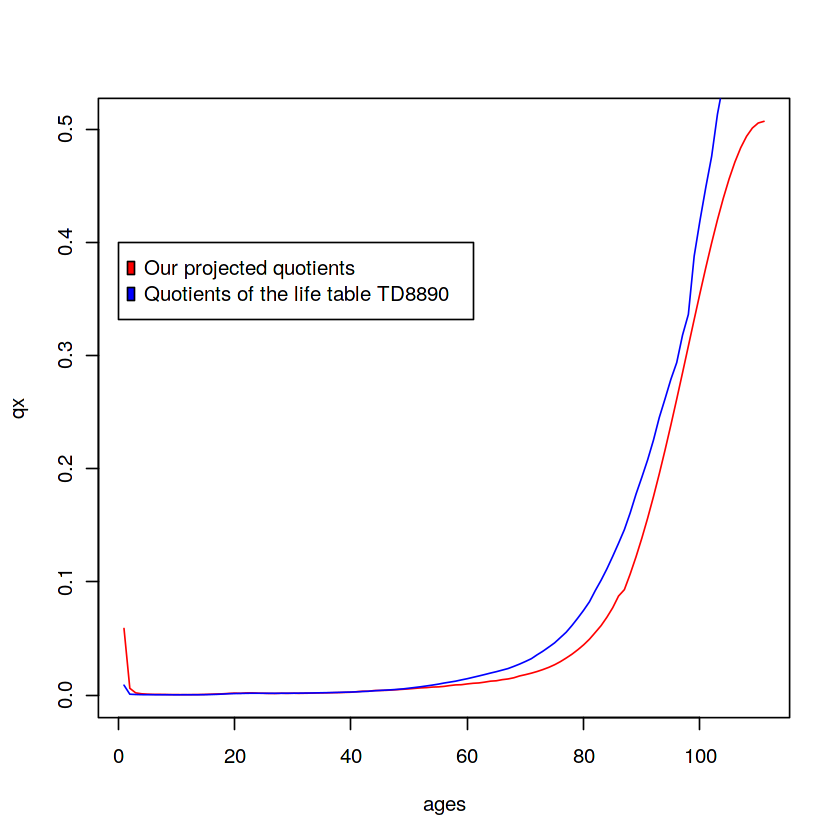

In [28]:


#Comparaison avec la TD8890
qx=c(extractCohort(fra2$Dxt[1:68,]/fra2$Ext[1:68,],cohort=1950),extractCohort(RHfor$rates, cohort = 1950),exp(regferm$fitted.values))
ages=1:111
plot(ages,qx,type="l",col="red")
lines((-diff(ltable$Lx.TD.88.90)/ltable$Lx.TD.88.90)[1:107],col="blue")
text=c("Our projected quotients","Quotients of the life table TD8890")
legend(0,0.4,legend=text,c("red","blue"), text.width = strwidth(text)[1]*3)


### A comparison in terms of life expectancy :

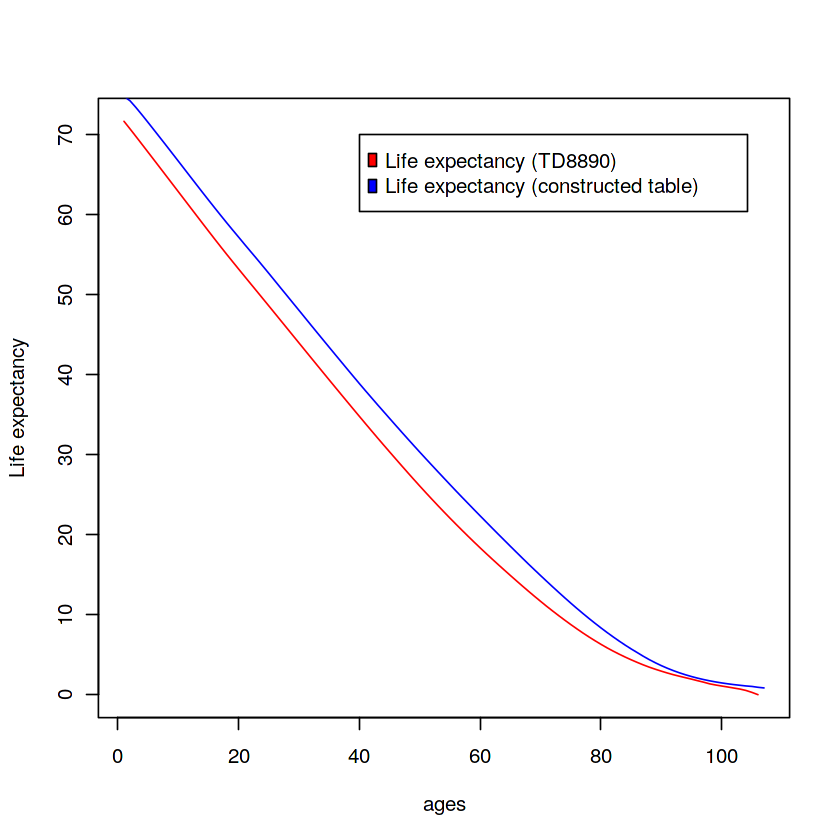

In [29]:


 Lx <- ltable$Lx.TD.88.90
 m <- length(Lx)
 p <- matrix(0,m,m); d <- p
 for(i in 1:(m-1)){
   p[1:(m-i),i] <- Lx[1+(i+1):m]/Lx[i+1]
   d[1:(m-i),i] <- (Lx[(1+i):(m)]-Lx[(1+i):(m)+1])/Lx[i+1]}
 diag(d[(m-1):1,]) <- 0
 diag(p[(m-1):1,]) <- 0
 qtd <- 1-p
 
 


 Lx2=100000*(1:111);
for(i in 1:111){
  Lx2[i+1]=(1-qx[i])*Lx2[i]
}
 Lx2=as.integer(Lx2)
 
 Lx <- Lx2
 m <- length(Lx2)
 p <- matrix(0,m,m); d <- p
 for(i in 1:(m-1)){
   p[1:(m-i),i] <- Lx[1+(i+1):m]/Lx[i+1]
   d[1:(m-i),i] <- (Lx[(1+i):(m)]-Lx[(1+i):(m)+1])/Lx[i+1]}
 diag(d[(m-1):1,]) <- 0
 diag(p[(m-1):1,]) <- 0
 qnew <- 1-p
 
 esp.vietd=function(x){sum(1-qtd[1:nrow(p),x])}
 esp.vienew=function(x){sum(1-qnew[1:nrow(p),x])}
 
 plottd=1:107
 for(i in 1:107){
   plottd[i]=esp.vietd(i)
 }
 plotnew=1:107
 for(i in 1:107){
   plotnew[i]=esp.vienew(i)
 }
 
 plot(plottd,type="l",col="red",xlab="ages",ylab="Life expectancy")
 lines(plotnew,col="blue")
text=c("Life expectancy (TD8890)","Life expectancy (constructed table)")
 legend(40,70,legend=text,c("red","blue"), , text.width = strwidth(text)[1]*3)
 